# CitiBike Destination Predictor

This project is a collaboration between [Elena Morais](https://github.com/elenasm7) and [Derrick Lewis](https://github.com/lewi0332)

The project requirements are to find and clean data to be fit to a classification algorithm to make predictions on the outcome. 

We chose to use data from CitiBike of all trips in 2018. This data includes time, start/stop locations, and some basic demographic identifiers. To aid in our perdiction we added daily weather information of New York City. 

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

The goal is to perdict the destination neighborhood of each journey based on the available variables. This is a multi-classification problem with a high number of outcomes. We determined that there are 51 qualifying neighborhoods in New York, which presents a sigificant challenge. 


## Data Collection and Cleaning

First we collected 1 year worth of trip data from Cibibike.com. We learn that there are 17million records in the 2018 data, which is too large for our processing capbabilities. Thus we import each month of data, and randomly sample 10% from each month to create a more manageable, yet representative list. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
for i in range(1,13):
    if i == 1:
        big = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = big.sample(frac=.1)
    else:
        temp = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = pd.concat([big, temp.sample(frac=.1)])

### NAN values

There are just 260 NaN values missing the station start and end points in the file of nearly 1.8million. This information is crucial to the prediction and thus can not be substituted. We have decidied to simply remove these rows. 

In [3]:
big = big.dropna()

### Convert to DateTime 

Start and End times are saved in a format that is not readable by Pandas or our future models. We will convert the columns with this information into a standard date format, then split the relevant information into individual columns to be used as a specific independant variable.

In [4]:
big['starttime'] = pd.to_datetime(big['starttime'])
big['start_month'] = big.starttime.dt.month
big['start_day_of_week'] = big.starttime.dt.dayofweek
big['start_hour'] = big.starttime.dt.hour
big['start_date'] = big.starttime.dt.day

big['starttime'] = big.starttime.dt.date
big['starttime'] = pd.to_datetime(big['starttime'])


### Insert Weather Data Here: 

https://www.weather.gov/okx/centralparkhistorical

Next we connect daily weather information. The hypothesis is that this may aide in predicting a destination as fair weather might increase trips to parks and beaches. 

In [5]:
weather_df = pd.read_csv('citibike_data/2018_weather.csv')
weather_df['starttime'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.drop(['max_temp', 'min_temp','departure', 'Hdd', 'cdd', 'new_snow', 'date' ], axis=1)                                               

In [6]:
big = pd.merge(big, weather_df, on='starttime', how='left')

### Insert Neighborhood Name

Connect Neighborhood name data to our 'End Station Latitude/Longitude' to use as labels for predictions. In the most widely used context there are 51 neighborhoods in New York City. 

In [7]:
neighborhoods = pd.read_csv('citibike_data/citibike_neighborhoods.csv')

In [8]:
neighborhoods['end station name'] = neighborhoods['stops']
neighborhoods = neighborhoods.drop(['Unnamed: 0', 'stops', 'end station latitude', 'end station longitude'], axis=1)

In [9]:
big = pd.merge(big, neighborhoods, on='end station name', how='left')

### Convert usertype to categories

Our CitiBike data includes a label for each trip to determine if it was made by a rider who is an annual subscriber or someone who has purchased a temporary pass. We assume that there may be destinations more likely chosen by tourist users. 

In [10]:
big.usertype = pd.Categorical(big.usertype)
big.usertype = big.usertype.cat.codes

### Bin Age into Categories

### Smooth '1969' birth year

### Label Encode for Morning versus Evening. 

To better fit a model, using a split day rather than by hour might aide in determining a destination. The idea is that many nieghborhoods are destinations for commuters going to work in the morning and alternatively heading home in the evening. 

### Remove redundant rows - 

Now that our primary categories are set we will remove features that are not needed or redundant. 

In [11]:
big = big.drop(['tripduration', 'starttime', 'stoptime','start station name',
                'end station id', 'bikeid', 'start station latitude', 
                'start station longitude', 'end station latitude', 
                'end station longitude','end station name', 'start_date'], axis=1)

### Save to CSV file to be used in later models 

In [238]:
#big.to_csv('citibike_2018.csv', index=False)

### View Correlation between varibles. 

In [14]:
df_small = big.sample(5000)

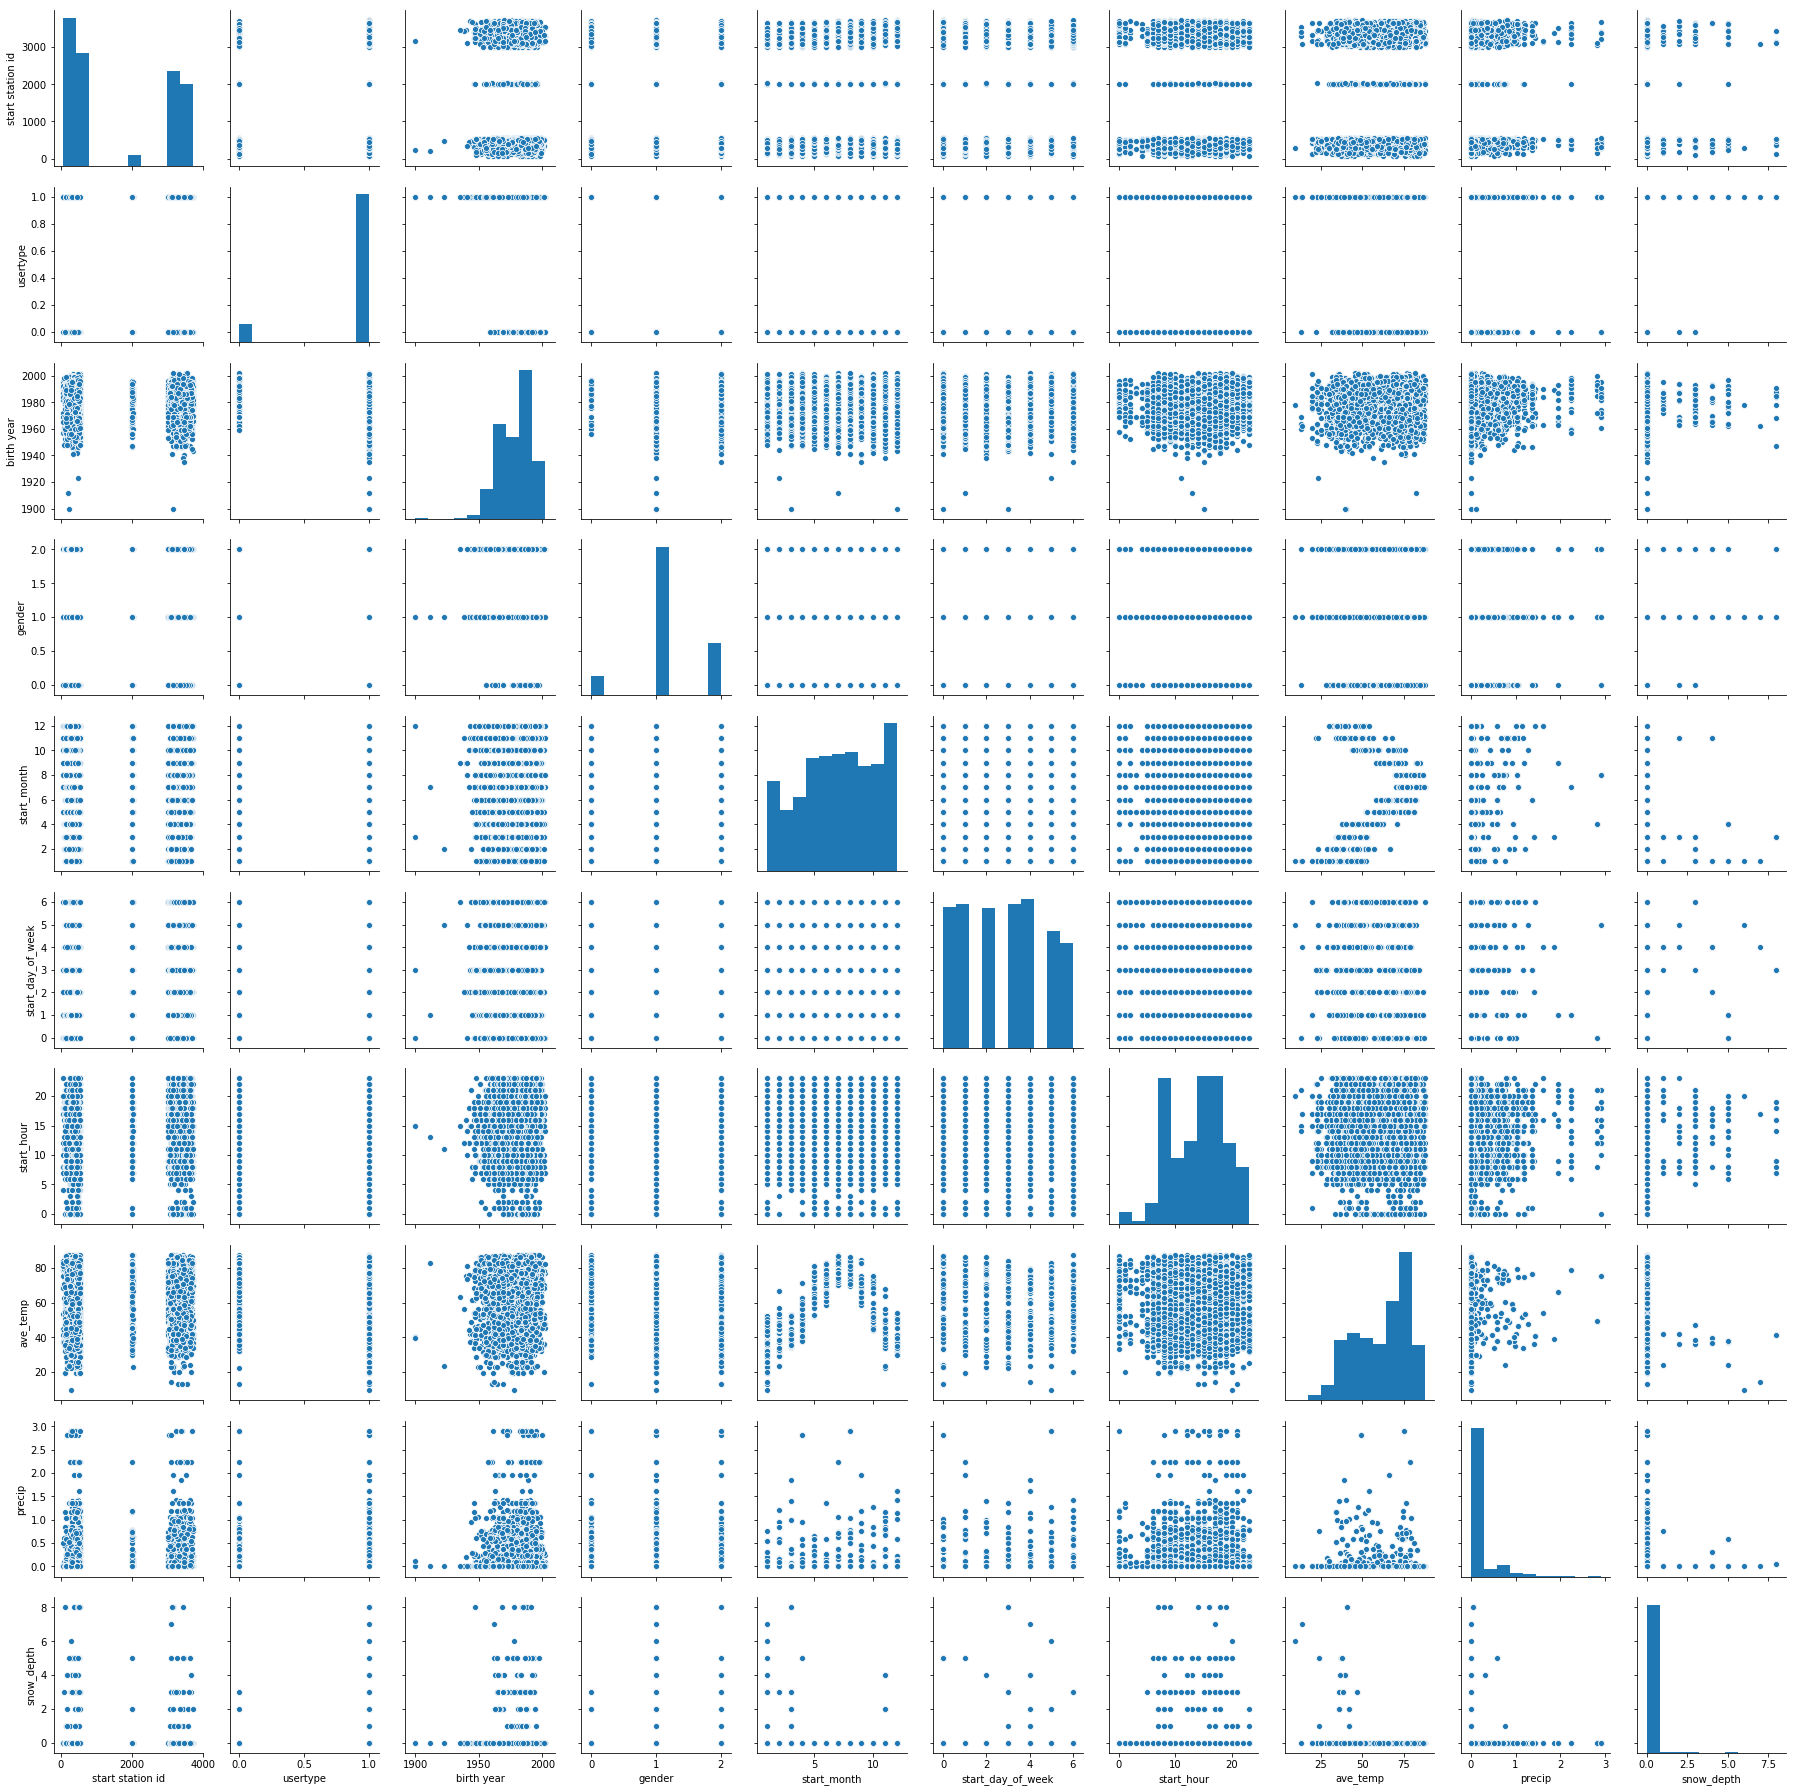

In [15]:
sns.pairplot(df_small)

### View the Volume of stop Neighborhoods.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(df_small.stop_nhbr)
plt.xticks(rotation=90)